In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models
from PIL import Image

import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

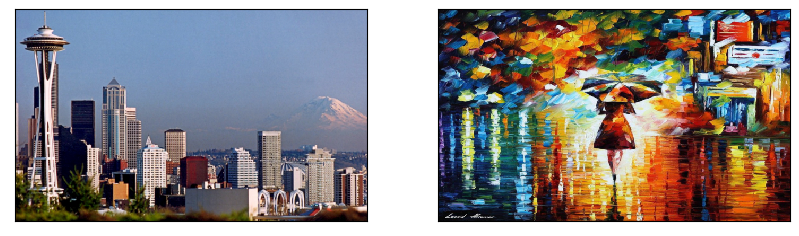

In [2]:
def load_image(image_path, size=None):
    orig_image = Image.open(image_path).convert('RGB')
    if size is None:
        size = orig_image.size
    transform = transforms.Compose([transforms.Resize(size=size),transforms.ToTensor()])
    tensor_image = transform(orig_image).unsqueeze(0)
    
    return orig_image, tensor_image


content_image, content = load_image('./images/space_needle.jpg', size=400)
style_image, style = load_image('./images/Rain_Princes_LeonidAfremov.jpg', size=tuple(content.shape[-2:]))

fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=100)
ax[0].imshow(np.clip(content[0,:,:,:].numpy().transpose(1,2,0), 0, 1))
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow(np.clip(style[0,:,:,:].numpy().transpose(1,2,0), 0, 1))
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

plt.show()

In [3]:
model = models.vgg19(pretrained=True).features

for param in model.parameters():
    param.requires_grad_(False)

In [4]:
layer_ids = [0, 5, 10, 19, 21, 28]
layer_names = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1']

style_layer_weight_list = [0.9, 0.7, 0.5, 0.3, np.NaN, 0.1]
style_layer_weights = {}
for i in range(len(style_layer_weight_list)):
    layer_name = layer_names[i]
    style_layer_weights[layer_name] = style_layer_weight_list[i]

In [5]:
def get_features(image, model, layer_ids, layer_names):
    features = {}
    x = image
    for layer_id, layer_operation in model._modules.items():
        x = layer_operation(x)
        layer_id = int(layer_id)
        if layer_id in layer_ids:
            layer_name = layer_names[layer_ids.index(layer_id)]
            features[layer_name] = x
    return features

In [6]:
def gram_matrix(features):
    gram = {}
    for layer_name, feature in features.items():
        b, d, h, w = feature.shape
        feature = feature.view(d, h * w)
        gram[layer_name] = torch.mm(feature, feature.t())
    return gram

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

content = content.to(device)
target = content.clone().requires_grad_(True).to(device)
style = style.to(device)
model = model.to(device)

optimizer = optim.Adam([target], lr = 0.005)

content_weight = 1
style_weight = 1e3

content_features = get_features(image=content, model=model, layer_ids=layer_ids, layer_names=layer_names)

Epoch 500/2000 ... Progress: 25.00% ... Total loss: 18287.955


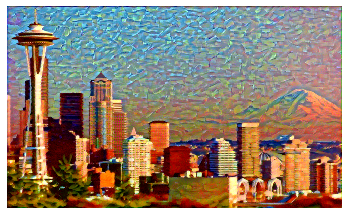

Epoch 1000/2000 ... Progress: 50.00% ... Total loss: 7970.545


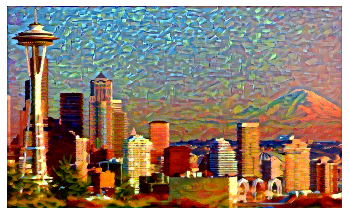

Epoch 1500/2000 ... Progress: 75.00% ... Total loss: 4404.2744


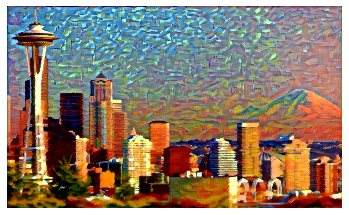

Epoch 2000/2000 ... Progress: 100.00% ... Total loss: 2652.3716


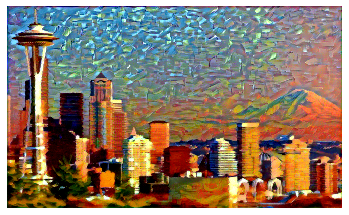

In [8]:
n_epochs = 2000

for iepoch in range(n_epochs):
    
    progress = (iepoch+1) / n_epochs * 100
    sys.stdout.write('\rEpoch {}/{} ... Progress: {:0.2f}% ... '.format(iepoch+1, n_epochs, progress))
    #sys.stdout.flush()
    
    target_features = get_features(image=target, model=model, layer_ids=layer_ids, layer_names=layer_names)
    style_features = get_features(image=style, model=model, layer_ids=layer_ids, layer_names=layer_names)
    
    content_loss = torch.mean( (target_features['conv4_2'] - content_features['conv4_2'])**2 )

    target_grams = gram_matrix(target_features)
    style_grams = gram_matrix(style_features)

    style_loss = 0
    for layer_name in layer_names:
        if layer_name != 'conv4_2':
            d, hw = target_grams[layer_name].shape
            layer_style_loss = style_layer_weights[layer_name] * torch.mean( (target_grams[layer_name] - style_grams[layer_name])**2 )
            style_loss += layer_style_loss / (d * hw)
    #         
    total_loss = content_weight*content_loss + style_weight*style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if (iepoch+1)%500 == 0:
        print('Total loss:', total_loss.to('cpu').detach().numpy())
        plt.imshow(np.clip(target[0,:,:,:].to('cpu').detach().numpy().transpose(1,2,0), 0, 1))
        plt.axis('off')
        plt.savefig('./images/seattle-rain'+str(iepoch+1)+'.jpg')
        plt.show()